<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/MLBox/MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH: MLBox

# Install the necessary library
Run the install code in the code cell below.

In [1]:
# Insert any install comamnds in this cell
!pip install mlbox

     |████████████████████████████████| 20.2MB 1.4MB/s 
     |████████████████████████████████| 13.0MB 184kB/s 
     |████████████████████████████████| 1.9MB 42.6MB/s 
     |████████████████████████████████| 10.4MB 39.7MB/s 
     |████████████████████████████████| 296kB 51.5MB/s 
     |████████████████████████████████| 7.0MB 38.3MB/s 
     |████████████████████████████████| 86.3MB 51kB/s 
     |████████████████████████████████| 1.2MB 38.2MB/s 
     |████████████████████████████████| 4.3MB 39.5MB/s 
     |████████████████████████████████| 112kB 58.0MB/s 
     |████████████████████████████████| 1.7MB 40.5MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 450kB 40.9MB/s 
     |████████████████████████████████| 3.8MB 37.3MB/s 
  Created wheel for mlbox: filename=mlbox-0.8.5-cp37-none-any.whl size=43754 sha256=f14b8d369ae55b0589bc3580d10ec35dbf0fd536f980805e973bd39921325b27
  Stored in directory: /root/.cache/pip/wheels/45/71/0e/b72acfbcdaaf1

# Preprocessing Section

In [1]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [3]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [6]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [7]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [8]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [9]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

# Model Section

In [10]:
# Prepare the data
def prepare_data(num):
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)

    # Change each positive and negative value to 1 and 0 respectively    
    imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # # For testing, a much smaller dataset is going to be used
    # imdb_df = imdb_df.head(5000)

    # Group all the negative reviews and get the first 2500
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:num]
    # imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:num]
    
    # Group all the positive and get the first 2500
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:num]
    # imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:num]
    
    test_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = test_df['review'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(len(feature_vector))
    print(f"Execution time is {end - start} secs")
    print("="*50)

    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = test_df['sentiment'].values
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    # Creating train and test data
    # The splits will be 80:20 
    no_samples = 0.8
    
    # This gets the percentage of indexes from feature vector and uses those for training
    X_train = feature_vector[0:int(no_samples*len(feature_vector))]
    y_train = labels[0:int(no_samples*len(labels))]
    
    # Go from the index that was used for training to the final
    X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
    y_test = labels[int(no_samples*len(labels)):len(labels)]

    return X_train, y_train, X_test, y_test

    # return feature_vector, labels

# Example code:

https://www.kaggle.com/axelderomblay/running-mlbox-auto-ml-package-on-titanic

# Youtube code:
https://www.youtube.com/watch?v=omd8SazsHaI&t=106s

https://github.com/sergeiissaev/youtube/blob/master/mlbox.ipynb

In [11]:
X_train, y_train, X_test, y_test = prepare_data(500)

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
tfidf_train = pd.DataFrame(columns = ['features', 'labels'])

# This is a dataframe with each row having a list
for i in range(len(X_train)):
  tfidf_train.loc[i] = [X_train[i].tolist()] + [y_train[i]]

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
tfidf_test = pd.DataFrame(columns = ['features'])

# This is a dataframe with each row having a list
for i in range(len(X_test)):
  tfidf_test.loc[i] = [X_test[i].tolist()]

print(tfidf_train.head())
print(tfidf_test.head())
print(len(tfidf_train))
print(len(tfidf_test))

tfidf_train.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_train.csv", index=False)
tfidf_test.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_test.csv", index=False)

Dataset loaded
Creating Feature Vector
Feature Vector Created
1000
Execution time is 5.417392015457153 secs
                                            features labels
0  [0.0035214087240691486, -0.012027380436188239,...      1
1  [-0.013724532349084316, -0.0603075334870282, -...      0
2  [0.07407407407407407, 0.07407407407407407, 0.0...      1
3  [0.045454545454545456, 0.023767215694560802, -...      1
4  [-0.013512037281255163, -0.03111102917981613, ...      1
                                            features
0  [-0.08770243610515403, -0.007694435683924697, ...
1  [-0.08281668330965139, -0.03452303418139355, -...
2  [-0.008433868725968595, -0.003952511017707303,...
3  [-0.018846104214696312, -0.10474487009563081, ...
4  [-0.0177345489316474, 0.10416666666666667, -0....
800
200


In [12]:
from mlbox.preprocessing import *
from mlbox.optimisation import *
from mlbox.prediction import *

In [13]:
paths = ["/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_train.csv", "/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_test.csv"]
target_name = "labels"

# Titanic example code

In [14]:
# Read and clean files
rd = Reader(sep = ",")
df = rd.train_test_split(paths, target_name)


reading csv : tfidf_train.csv ...
cleaning data ...
CPU time: 7.241692781448364 seconds

reading csv : tfidf_test.csv ...
cleaning data ...
CPU time: 4.26394510269165 seconds

> Number of common features : 1

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 1
> Number of numerical features: 0
> Number of training samples : 800
> Number of test samples : 200

> You have no missing values on train set...

> Task : classification
0.0    403
1.0    397
Name: labels, dtype: int64

encoding target ...


In [ ]:
# This can remove non stable features but probably shouldn't run at all for now
# dft = Drift_thresholder()
# df = dft.fit_transform(df)

In [15]:
opt = Optimiser(scoring = "accuracy", n_folds = 5)

/usr/local/lib/python3.7/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


In [16]:
space = {
    
        'est__strategy':{"search":"choice",
                                  "space":["LightGBM"]},    
        'est__n_estimators':{"search":"choice",
                                  "space":[150]},    
        'est__colsample_bytree':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__subsample':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__max_depth':{"search":"choice",
                                  "space":[5,6,7,8,9]},
        'est__learning_rate':{"search":"choice",
                                  "space":[0.07]} 
    
        }

print("Creating Fit the model")
print("="*50)
start = time.time()
params = opt.optimise(space, df,15)
end = time.time()
print("="*50)
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)

Creating Fit the model
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.9279982135866999, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8229503163927033, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
MEAN SCORE : accuracy = 0.49624999999999997
VARIANCE : 0.003061862178478962 (fold 1 = 0.5, fold 2 = 0.5, fold 3 = 0.49375, fold 4 = 0.49375, fold 5 = 0.49375)
CPU time: 1.218299150466919 s


fitting the pipeline ...
CPU time: 0.3269679546356201 seconds


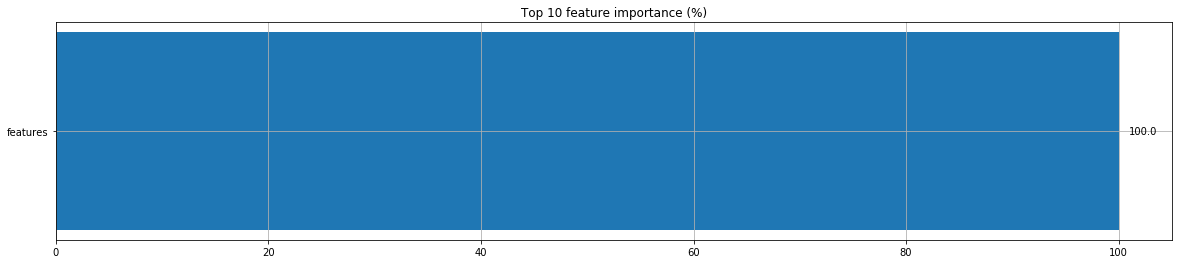


> Feature importances dumped into directory : save

predicting ...
CPU time: 0.030610084533691406 seconds

> Overview on predictions : 

      0.0     1.0  labels_predicted
0  0.4423  0.5577                 1
1  0.4423  0.5577                 1
2  0.4423  0.5577                 1
3  0.4423  0.5577                 1
4  0.4423  0.5577                 1
5  0.4423  0.5577                 1
6  0.4423  0.5577                 1
7  0.4423  0.5577                 1
8  0.4423  0.5577                 1
9  0.4423  0.5577                 1

dumping predictions into directory : save ...


In [17]:
prd = Predictor()
prd.fit_predict(params, df)

In [21]:
from sklearn.metrics import accuracy_score
y_pred = predict_output_vals
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

Test Accuracy score 0.47


In [72]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[ 97   0]
 [103   0]]
True positives: 0.485 %
True negatives: 0.0 %
False positives: 0.515 %
False negatives: 0.0 %


In [75]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


In [ ]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

In [73]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.5


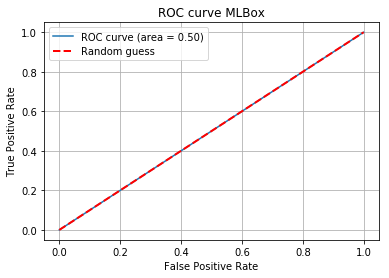

In [76]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve MLBox')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# ===================================================

# Old

In [18]:
predict_output = pd.read_csv("save/labels_predictions.csv")
print(predict_output.head())
# print(predict_output["labels_predicted"].values)
predict_output_vals = (predict_output["labels_predicted"].values)
print(predict_output_vals)

   Unnamed: 0     0.0     1.0  labels_predicted
0           0  0.4423  0.5577                 1
1           1  0.4423  0.5577                 1
2           2  0.4423  0.5577                 1
3           3  0.4423  0.5577                 1
4           4  0.4423  0.5577                 1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


# ==============================================================

# Text data values

In [ ]:
X_train, y_train, X_test, y_test = prepare_data(1000)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

Dataset loaded
Creating Feature Vector
Feature Vector Created
2000
Execution time is 10.602584838867188 secs
1600
1600
400
400


# MLBOX EXample

In [ ]:
# This is a dataframe with a column for each value
tfidf_train = pd.DataFrame(X_train)

# Add the labels
tfidf_train['labels'] = y_train

# This is a dataframe with a column for each value
tfidf_test = pd.DataFrame(X_test)

# # Add the labels
# tfidf_test['labels'] = y_test

print(tfidf_train.head())
print(tfidf_test.head())

tfidf_train.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_train.csv", index=False)
tfidf_test.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_test.csv", index=False)

                                                   0    labels
0  You cannot deny that we have an affinity for s...  negative
1  This video is so hilariously funny, it makes e...  positive
2  Cinema's greatest period started in post-War E...  positive
3  The only reason I gave this episode of "Master...  negative
4  Everyone, my name may sound weird, but there w...  positive
                                                   0
0  This film was very well advertised. I am an av...
1  Bela Lugosi appeared in several of these low b...
2  The film began with Wheeler sneaking into the ...
3  *Sigh* Leave it to us Finns to take a stupid i...
4  I cannot hate on the show. When the old (and b...


In [ ]:
# This is a dataframe with a column for each value
tfidf_train = pd.DataFrame(X_train)

# Add the labels
tfidf_train['labels'] = y_train

# This is a dataframe with a column for each value
tfidf_test = pd.DataFrame(X_test)

# # Add the labels
# tfidf_test['labels'] = y_test

print(tfidf_train.head())
print(tfidf_test.head())

tfidf_train.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_train.csv", index=False)
tfidf_test.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_test.csv", index=False)

          0         1         2         3  ...  18194  18195  18196  labels
0 -0.023502  0.001864  0.001864 -0.000110  ...    0.0    0.0    0.0       0
1 -0.178181 -0.015686  0.011884 -0.025241  ...    0.0    0.0    0.0       1
2 -0.003631 -0.001029 -0.001888  0.003195  ...    0.0    0.0    0.0       1
3 -0.016810 -0.065333 -0.012724 -0.003798  ...    0.0    0.0    0.0       0
4 -0.010612 -0.009287 -0.006086 -0.109171  ...    0.0    0.0    0.0       1

[5 rows x 18198 columns]
      0         1         2         3      ...  18193  18194  18195  18196
0 -0.116666 -0.020894 -0.129446  0.011905  ...    0.0    0.0    0.0    0.0
1  0.061728  0.017259 -0.002520 -0.007015  ...    0.0    0.0    0.0    0.0
2 -0.092818  0.030244  0.004808 -0.000199  ...    0.0    0.0    0.0    0.0
3  0.020408 -0.012287  0.014265 -0.016171  ...    0.0    0.0    0.0    0.0
4 -0.003952  0.002573 -0.005665  0.002573  ...    0.0    0.0    0.0    0.0

[5 rows x 18197 columns]


In [ ]:
data = Reader(sep=",").train_test_split(paths, target_name)  
# data = Drift_thresholder().fit_transform(data)


reading csv : tfidf_train.csv ...
cleaning data ...


KeyboardInterrupt: ignored

In [ ]:
opt = Optimiser().evaluate(None, data)

/usr/local/lib/python3.7/dist-packages/mlbox/optimisation/optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}


MEAN SCORE : neg_log_loss = -0.7436369921808553
VARIANCE : 0.04981626174475273 (fold 1 = -0.6938207304361026, fold 2 = -0.7934532539256081)
CPU time: 0.8682150840759277 seconds



In [ ]:
space = {

        'ne__numerical_strategy' : {"space" : [0, 'mean']},

        'ce__strategy' : {"space" : ["label_encoding", "random_projection", "entity_embedding"]},

        'fs__strategy' : {"space" : ["variance", "rf_feature_importance"]},
        'fs__threshold': {"search" : "choice", "space" : [0.1, 0.2, 0.3]},

        'est__strategy' : {"space" : ["LightGBM"]},
        'est__max_depth' : {"search" : "choice", "space" : [5,6]},
        'est__subsample' : {"search" : "uniform", "space" : [0.6,0.9]}

        }

params = opt.optimise(space, df, 15)
bestsd = opt.optimise(space, data, max_evals = 5)

AttributeError: ignored


fitting the pipeline ...
CPU time: 0.14380288124084473 seconds


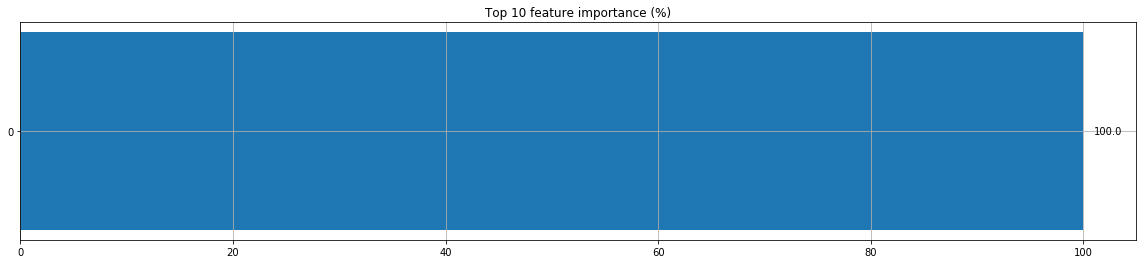


> Feature importances dumped into directory : save

predicting ...
CPU time: 0.035979509353637695 seconds

> Overview on predictions : 

   negative  positive labels_predicted
0  0.496204  0.503796         positive
1  0.496204  0.503796         positive
2  0.496204  0.503796         positive
3  0.496204  0.503796         positive
4  0.496204  0.503796         positive
5  0.496204  0.503796         positive
6  0.496204  0.503796         positive
7  0.496204  0.503796         positive
8  0.496204  0.503796         positive
9  0.496204  0.503796         positive

dumping predictions into directory : save ...


TypeError: ignored

In [ ]:
Predictor().fit_predict(best, data)

# Output Pandsa Dataframe

In [ ]:
# Importing data using pandas
import pandas as pd

feature_vector, labels = prepare_data(500)

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
# tfidf_tf = pd.DataFrame(feature_vector)
tfidf_tf_2col = pd.DataFrame(columns = ['features', 'labels'])

# This is a dataframe with each row having a list
for i in range(len(feature_vector)):
  tfidf_tf_2col.loc[i] = [feature_vector[i].tolist()] + [labels[i]]

# This is a dataframe with a column for each value
tfidf_tf_mult = pd.DataFrame(feature_vector)

# Add the labels
tfidf_tf_mult['labels'] = labels

#==========================================

In [ ]:
print(tfidf_tf.head())
tfidf_tf.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_2col.csv", index=False)

print(tfidf_tf_mult.head())
tfidf_tf_mult.to_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_tf_mult.csv", index=False)

In [ ]:
load_ouput_csv_2col = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_2col.csv")

print(load_ouput_csv_2col.head())

In [ ]:
load_ouput_csv_mult = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/tfidf_tf_mult.csv")
print(load_ouput_csv_mult.head())